In [38]:
import numpy as np
import pandas as pd
from myfunc import *
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
from scipy import interpolate
from itertools import product
from tqdm import tqdm
"""
Consider add these later

# a kind of benefit : unbalancy


# a design option: if easy for elder

"""



'\nConsider add these later\n\n# a kind of benefit : unbalancy\n\n\n# a design option: if easy for elder\n\n'

In [39]:
need = pd.read_csv('trip_data.csv')
need['datetime'] = pd.to_datetime(need['時間'], format='%H:%M')
weekday_need = need[need['weekday']==1]
holiday_need = need[need['weekday']==0]


"""
About tatal demand:

for weekday:
rush time(7-10), (17-21) has most demand

for holiday:
    time coming home (20) has most demand
    
weekday > holiday
"""

input_ranges = {
    #more cost, and able to satisfy more demand
    'n_cars': range(0, 1001, 10), 
    
    # time depends how many demand the cars are serving
    
    'weekday_starthour': range(0, 24),
    'weekday_startmin': range(0,31,30),
    'weekday_endhour': range(0, 24),
    'weekday_endmin': range(0, 31, 30),
    'holiday_starthour': range(0, 24),
    'holiday_startmin': range(0, 31, 30),
    'holiday_endhour': range(0, 24),
    'holiday_endmin': range(0, 31, 30),
    
    # more cost, but car can save charging time to serve more demand
    'charge_on_road': [True, False],
    
    # more cost, but can facilitate demand
    'service_lev': range(1, 11), 
    
    #lead to lower demand
    'once_fare':range(0,3001, 100) # yen
    }
weekday_need

,weekday,時間,トリップ数,平均トリップ距離,datetime
0,1,00:00,339,3.07,1900-01-01 00:00:00
1,1,00:30,265,3.00,1900-01-01 00:30:00
2,1,01:00,214,3.04,1900-01-01 01:00:00
3,1,01:30,198,2.95,1900-01-01 01:30:00
4,1,02:00,222,3.02,1900-01-01 02:00:00
5,1,02:30,210,2.97,1900-01-01 02:30:00
6,1,03:00,220,3.01,1900-01-01 03:00:00
7,1,03:30,194,3.05,1900-01-01 03:30:00
8,1,04:00,182,2.96,1900-01-01 04:00:00
9,1,04:30,210,3.00,1900-01-01 04:30:00


In [40]:
holiday_need['トリップ数'].sum(),weekday_need['トリップ数'].sum()


(15399, 26165)

In [41]:
def compute_duration(start_time, end_time):
    """
        Computes the elapsed time between the start time and end time in hours.

        weekday_start_time: The start time.
        weekday_end_time: The end time.

        Returns: The elapsed time in hours as a float.
        """
    # Compute the time difference.
    time_diff = end_time - start_time

    # Convert the time difference to hours.
    elapsed_time_hours = time_diff.total_seconds() / 3600

    return elapsed_time_hours


def filter_need(need, start_hour, start_minute, end_hour, end_minute):
    start_time = dt.datetime(1900, 1, 1, start_hour, start_minute).time()
    end_time = dt.datetime(1900, 1, 1, end_hour, end_minute).time()

    if start_time < end_time:
        filtered_need = need[(need['datetime'].dt.time >= start_time) & (
            need['datetime'].dt.time < end_time)]["トリップ数"]
    else:  # If the time period crosses over to the next day
        filtered_need = need[(need['datetime'].dt.time >= start_time) | (
            need['datetime'].dt.time < end_time)]["トリップ数"]

    return filtered_need


In [42]:
def integrate_normal_distribution(a, b, mu=0, sigma=1):
    """
        Integrate the normal distribution from a to b.

        Parameters:
        a (float): The lower limit of integration.
        b (float): The upper limit of integration.
        mu (float): The mean of the normal distribution. Default is 0.
        sigma (float): The standard deviation of the normal distribution. Default is 1.

        Returns:
        float: The result of the integration.
        """
    # Define the probability density function of the normal distribution.
    def pdf(x): return norm.pdf(x, mu, sigma)

    # Integrate the pdf from a to b.
    result, _ = quad(pdf, a, b)

    return result

def real_demand_function(fare):
    """
    Calculate the demand based on the fare and need.

    Parameters:
    fare (float): The fare.

    Returns:
    float: The demand.
    """

    # make fare=0.05 at mu(=0) in the nomal distribution
    # a mapping between fare(0~0.3) and f(-1000~1000)
    if fare < 0.05:
        f = 20000*fare - 1000
    else:
        f = 4000*fare-200
    idx = integrate_normal_distribution(f, float('inf'), 0, 200)
    
    return (idx+0.25)*0.8  # to make 1>new need>0.2

def get_interpolated_demand_fuction():

    demand = []
    fare_range = np.arange(0, 0.3001, 0.012)
    for f in fare_range:
        demand.append(real_demand_function(f))
    return interpolate.interp1d(fare_range, demand, kind='quadratic')


interpolated_demand_fuction = get_interpolated_demand_fuction()
'''
Usage: need *= interpolated_demand_fuction(target_fare)
'''


'\nUsage: need *= interpolated_demand_fuction(target_fare)\n'

In [43]:


class Model():
    """
    This Model class represents a business model for a car service.
    It includes initial parameters of the service such as the number of cars, hours of operation,
    whether or not the cars can charge on the road, and service level.
    It has methods to calculate the revenue and cost of the business model.
    """
    def __init__(self, input_values={
        'n_cars': 300,
        'weekday_starthour': 8,
        'weekday_startmin': 30,
        'weekday_endhour': 18,
        'weekday_endmin': 0,
        'holiday_starthour': 9,
        'holiday_startmin': 0,
        'holiday_endhour': 20,
        'holiday_endmin': 0,
        'charge_on_road': True,
        'service_lev': 5, 
        'once_fare': 500,
    }, need=pd.DataFrame(), car_speed=24, car_sharing_rate=1.5, years=10, ) -> None:
        
        """
        Initializes the Model with the given input values.
        """

        self.n_cars = input_values['n_cars']
        self.weekday_starthour = input_values['weekday_starthour']
        self.weekday_startmin = input_values['weekday_startmin']
        self.weekday_endhour = input_values['weekday_endhour']
        self.weekday_endmin = input_values['weekday_endmin']
        self.holiday_starthour = input_values['holiday_starthour']
        self.holiday_startmin = input_values['holiday_startmin']
        self.holiday_endhour = input_values['holiday_endhour']
        self.holiday_endmin = input_values['holiday_endmin']
        self.charge_on_road = input_values['charge_on_road']
        self.service_lev = input_values['service_lev']
        self.once_fare = input_values['once_fare']*0.0001

        self.weekday_start_time = dt.datetime(1900, 1, 1,
                                              hour=self.weekday_starthour, minute=self.weekday_startmin)
        self.weekday_end_time = dt.datetime(
            1900, 1, 1, hour=self.weekday_endhour, minute=self.weekday_endmin)

        self.weekday_run_time = compute_duration(
            self.weekday_start_time, self.weekday_end_time)

        self.holiday_start_time = dt.datetime(1900, 1, 1,
                                              hour=self.holiday_starthour, minute=self.holiday_startmin)
        self.holiday_end_time = dt.datetime(
            1900, 1, 1, hour=self.holiday_endhour, minute=self.holiday_endmin)

        self.holiday_run_time = compute_duration(
            self.holiday_start_time, self.holiday_end_time)
        
        
        self.car_speed = car_speed 
        self.car_sharing_rate = car_sharing_rate  # no car sharing = 2 つまり、往復(=2)しないと新しい乗客を乗せられない
        self.calculation_years = years
        need['datetime'] = pd.to_datetime(need['時間'], format='%H:%M')
        self.weekday_need = need[need['weekday'] == 1]
        self.holiday_need = need[need['weekday'] == 0]
        self.interpolated_demand_fuction= interpolated_demand_fuction
        
    # service_effect: Computes the effective need based on the service level.
    @staticmethod
    def service_effect(need, service_lev):
        """
        need: The raw need value.
        service_lev: The service level.

        Returns: The effective need considering the service level.
        """
        return need * (100 + service_lev * 3)/100

    @staticmethod
    def bulk_order_total_cost(n_items, base_price, discount_factor):
        """
        Computes the total cost of items, taking into account a volume discount.

        n_items: The number of items being purchased.
        base_price: The base price per item without any discounts.
        discount_factor: The discount factor that is multiplied by the square root of the number of items.

        Returns: The total cost of the items.
        """
        # Compute the discounted price per item.
        discounted_price = base_price * (1 - discount_factor * (n_items ** 0.5))

        # Ensure the price does not go below 0.4*base_price.
        discounted_price = max(discounted_price, 0.4*base_price)

        # Compute the total cost.
        total_cost = n_items * discounted_price

        return total_cost
        
        
    # revenue: Computes the revenue for the given car service scenario.


    def compute_revenue(self):
        """
        Returns: The computed revenue for the given parameters.
        """
        n_cars = self.n_cars
        

        car_sharing_rate = self.car_sharing_rate
        car_speed = self.car_speed
        years = self.calculation_years
        once_fare = self.once_fare
        
        
        # Extracting real need data for weekdays and holidays within provided time range.
        
        def filter_need(need, start_hour, start_minute, end_hour, end_minute):
            start_time = dt.datetime(1900, 1, 1, start_hour, start_minute).time()
            end_time = dt.datetime(1900, 1, 1, end_hour, end_minute).time()

            if start_time < end_time:
                filtered_need = need[(need['datetime'].dt.time >= start_time) & (
                    need['datetime'].dt.time < end_time)]["トリップ数"]
            else:  # If the time period crosses over to the next day
                filtered_need = need[(need['datetime'].dt.time >= start_time) | (
                    need['datetime'].dt.time < end_time)]["トリップ数"]

            return filtered_need
        weekday_real_need = filter_need(
            weekday_need, self.weekday_starthour, self.weekday_startmin, self.weekday_endhour, self.weekday_endmin)

        holiday_real_need = filter_need(
            holiday_need, self.holiday_starthour, self.holiday_startmin, self.holiday_endhour, self.holiday_endmin)

        # Apply service effect to the real need data.
        weekday_real_need = weekday_real_need.apply(
            self.service_effect, args=(self.service_lev,))
        weekday_real_need*=interpolated_demand_fuction(self.once_fare)
        self.weekday_real_need = weekday_real_need

        holiday_real_need = holiday_real_need.apply(
            self.service_effect, args=(self.service_lev,))
        holiday_real_need *=interpolated_demand_fuction(self.once_fare)
        self.holiday_real_need = holiday_real_need
        
        # print(interpolated_demand_fuction(self.once_fare))

        # Calculation for the total revenue.
        
        
        # Max trips one car can handle in 0.5h (trip in a row)
        if self.charge_on_road:
            car_sharing_rate * 0.8
        max_trip_per_car = 0.5 * (1 / (3 * car_sharing_rate / car_speed))

        # n_trip per day
        n_trip = 2/3 * weekday_real_need.apply(min, args=(n_cars * max_trip_per_car,)).sum() + \
            1/3 * holiday_real_need.apply(min,
                                        args=(n_cars * max_trip_per_car,)).sum()
            
        # print(n_trip, once_fare)
        self.n_trip = n_trip * 365 * years
        self.revenue = self.n_trip*once_fare

        return self.revenue


    def compute_cost(self):
        """

        Returns: The computed cost for the given parameters.
        """
        years = self.calculation_years
        
        n_cars = self.n_cars
        service_lev = self.service_lev
        weekday_run_time = self.weekday_run_time
        holiday_run_time = self.holiday_run_time

        # Basic cost of maintaining the fleet of cars, adjusted by the number of cars.
        if self.charge_on_road:
            base_cost = 10_0000
        else:
            base_cost = 5_0000 + 5000 * np.log1p(n_cars)

        car_cost = self.bulk_order_total_cost(n_cars, 600, 0.1)
        # Additional cost of the service, depending on the service level.
        service_cost = n_cars * service_lev / 10 * 600 * years
        # service_lev 1-10 : 100-10 car assign 1 service person

        # Running cost, depending on the total run time on weekdays and holidays.
        run_cost = weekday_run_time * 2/3 * n_cars + holiday_run_time / 3 * n_cars
        run_cost *= 10*years
         
        self.base_cost = base_cost
        self.car_cost = car_cost
        self.service_cost = service_cost
        self.run_cost = run_cost
        self.cost = base_cost + service_cost + run_cost+car_cost
        return self.cost
    
    def compute_profit(self):
        self.profit = self.compute_revenue() - self.compute_cost()
        return self.profit
    
    def compute_benefit(self):
        # self.travel_benefit = self.n_trip*0.1*0.8
        # self.time_benefit = (41-29)*self.n_trip*3/self.car_speed*60*1E-4
        # self.benefit = self.travel_benefit + self.time_benefit- paid
        # print('benefit:', travel_benefit , time_benefit , paid)
        
    
        self.surplus = quad(interpolated_demand_fuction,self.once_fare, 0.3)[0]*self.n_trip
        
        self.benefit = self.surplus

        
        return self.benefit
    
    def run(self):
        self.compute_profit()
        self.compute_benefit()
    
    def output(self):
        # have to do after model.run()
        # print(self.profit, self.benefit)
        return self.profit, self.benefit

In [44]:
def check_input_range(input_values, input_ranges):
    for key in input_values.keys():
        if key in input_ranges:
            if input_values[key] not in input_ranges[key]:
                print(
                    f"Input value for {key} is out of range. Your value is {input_values[key]}. The range is{input_ranges[key]}")
                return False
        else:
            print(f"No range defined for {key}")
            return False
    return True

In [45]:
def fit_time_fare_plot(input_values, type= 'profit'):
    n_cars_range = np.arange(0, 1001, 100)  # range of car numbers
    service_lev_range = np.arange(1, 11, 2)  # range of service levels

    # Initialize arrays for various metrics
    revenues = np.zeros_like(n_cars_range, dtype=float)
    costs = np.zeros_like(n_cars_range, dtype=float)
    profits = np.zeros_like(n_cars_range, dtype=float)
    base = np.zeros_like(n_cars_range, dtype=float)
    runs = np.zeros_like(n_cars_range, dtype=float)
    service = np.zeros_like(n_cars_range, dtype=float)
    cars = np.zeros_like(n_cars_range, dtype=float)
    travel_benefit = np.zeros_like(n_cars_range, dtype=float)
    time_benefit = np.zeros_like(n_cars_range, dtype=float)
    
    
    width = 20  # bar width for the cost graph
    fig, axs = plt.subplots(2, 5, figsize=(20, 10), sharey=True)
    fig.suptitle(
        'Revenue, Cost and Profit vs Number of Cars for Different Service Levels and Charge on Road Scenarios')

    for i, service_lev in enumerate(service_lev_range):
        for j, charge_on_road in enumerate([True, False]):
            # Calculate metrics for all car numbers
            for k, n_cars in enumerate(n_cars_range):
                input_values.update(
                {'service_lev': service_lev, 'charge_on_road': charge_on_road, 'n_cars': n_cars})

                m = Model(input_values, need)  # initialize model
                m.run() # compute
                revenues[k], costs[k] = m.revenue, m.cost
                base[k], service[k], cars[k], runs[k] = m.base_cost, m.service_cost, m.car_cost, m.run_cost
                travel_benefit[k], time_benefit[k], revenues[k] = m.travel_benefit, m.time_benefit, m.revenue

            if type == 'profit':
                profits = revenues - costs
                axs[j, i].plot(n_cars_range, revenues, label='Revenue')
                axs[j, i].plot(n_cars_range, costs, label='Cost')
                axs[j, i].plot(n_cars_range, profits, label='Profit')
                print(revenues , costs)

            elif type == 'cost':
                width = 20  # bar width for the cost graph
                axs[j, i].bar(n_cars_range, base,
                              label='Base Cost', width=width)
                axs[j, i].bar(n_cars_range, service, bottom=base,
                              label='Service Cost', width=width)
                axs[j, i].bar(n_cars_range, cars, bottom=np.array(
                    base) + np.array(service), label='Cars Cost', width=width)
                axs[j, i].bar(n_cars_range, runs, bottom=np.array(
                    base) + np.array(service) + np.array(cars), label='Runs Cost', width=width) 
                axs[j, i].set_title(
                    f'Service Lev: {service_lev}, Charge on Road: {charge_on_road}')
            
            elif type =='benefit':
                
                axs[j, i].bar(n_cars_range, travel_benefit,
                              label='Travel Benefit', width=width)
                axs[j, i].bar(n_cars_range, time_benefit, bottom=travel_benefit,
                              label='Time Benefit', width=width)
                
                axs[j, i].bar(n_cars_range, revenues, label='Paid', width=width, align = 'edge')
                axs[j, i].set_title(
                    f'Service Lev: {service_lev}, Charge on Road: {charge_on_road}')

        

    plt.legend()
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()


In [46]:
def demand_plot(input_values):
    
    fare_range = range(0, 3001, 100)
    demand = np.zeros_like(fare_range)
    for i, fare in enumerate(fare_range):
        input_values['once_fare'] = fare
        m = Model(input_values,need)
        m.compute_profit()
        demand[i] = m.n_trip
        
    
    plt.plot(fare_range, demand)
    plt.show()

In [47]:


def all_consensus_plot(input_values, input_ranges, step_sizes={
    'n_cars': 300,
    'weekday_starthour': 4,
    'weekday_endhour': 4,
    'holiday_starthour': 4,
    'holiday_endhour': 4,
    'service_lev': 3,
    'once_fare': 500, 
    'weekday_startmin':31,
    'weekday_endmin': 31,
    'holiday_startmin': 31,
    'holiday_endmin': 31,
}):

    # Adjust input_ranges according to step_sizes
    adjusted_input_ranges = {
        key: range(min(value), max(value) + 1, step_sizes.get(key, 1)
                   ) if isinstance(value, range) else value
        for key, value in input_ranges.items()
    }
    # Generate all combinations of input values
    keys, values = zip(*adjusted_input_ranges.items())
    all_input_combinations = [dict(zip(keys, v)) for v in product(*values)]

    print(len(all_input_combinations))
    # Initialize arrays for various metrics
    profits = np.zeros(len(all_input_combinations), dtype=float)
    benefits = np.zeros(len(all_input_combinations), dtype=float)
    n_cars_values = np.zeros(len(all_input_combinations), dtype=float)
    once_fare_values = np.zeros(len(all_input_combinations), dtype=float)

    # Iterate over all input combinations
    for i, input_combination in enumerate(tqdm(all_input_combinations)):
        # Update input_values with the current combination
        input_values.update(input_combination)
        if input_values['n_cars']==0:
            input_values['n_cars'] = 100

        # Initialize a model
        m = Model(input_values, need)
        m.run()
        # Compute profit and benefit
        # print(m.output())
        profits[i], benefits[i] = m.output()
        if benefits[i]<0:
            print(m.travel_benefit, m.time_benefit, m.revenue)
        n_cars_values[i] = input_values['n_cars']
        once_fare_values[i] = input_values['once_fare']
        
        
        if i >=9999:
            break


    n_cars_values = (n_cars_values - min(n_cars_values)) / \
        (max(n_cars_values) - min(n_cars_values))
    once_fare_values = (once_fare_values - min(once_fare_values)) / \
        (max(once_fare_values) - min(once_fare_values))
    
    
    # Create scatter plot
    plt.scatter(profits, benefits, c=n_cars_values,marker='.', alpha=0.01)


    plt.colorbar(label='n_cars')

    plt.xlabel('Profit')
    plt.ylabel('Benefit')
    plt.title('Profit and Benefit for all input combinations')
    plt.show()


In [48]:
def main(input_values, input_ranges, need):
    if not check_input_range(input_values, input_ranges):
        raise ValueError("One or more input values are out of range")
    

    # demand_plot(input_values, )
    
    # fit_time_fare_plot(input_values, 'benefit')
    all_consensus_plot(input_values, input_ranges)
    plt.show()
    

In [3]:
import pandas as pd

input_values = {
    'n_cars': 300,
    'weekday_starthour': 8,
    'weekday_startmin': 30,
    'weekday_endhour': 18,
    'weekday_endmin': 0,
    'holiday_starthour': 9,
    'holiday_startmin': 0,
    'holiday_endhour': 20,
    'holiday_endmin': 0,
    'charge_on_road': True,
    'service_lev': 5, 
    'once_fare': 500
}

df = pd.DataFrame(input_values, index=[0])
df

,n_cars,weekday_starthour,weekday_startmin,weekday_endhour,weekday_endmin,holiday_starthour,holiday_startmin,holiday_endhour,holiday_endmin,charge_on_road,service_lev,once_fare
0,300,8,30,18,0,9,0,20,0,True,5,500


290304


  3%|▎         | 9999/290304 [01:46<49:53, 93.65it/s]  


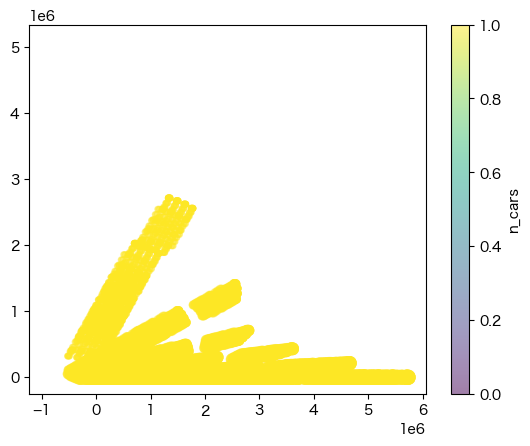

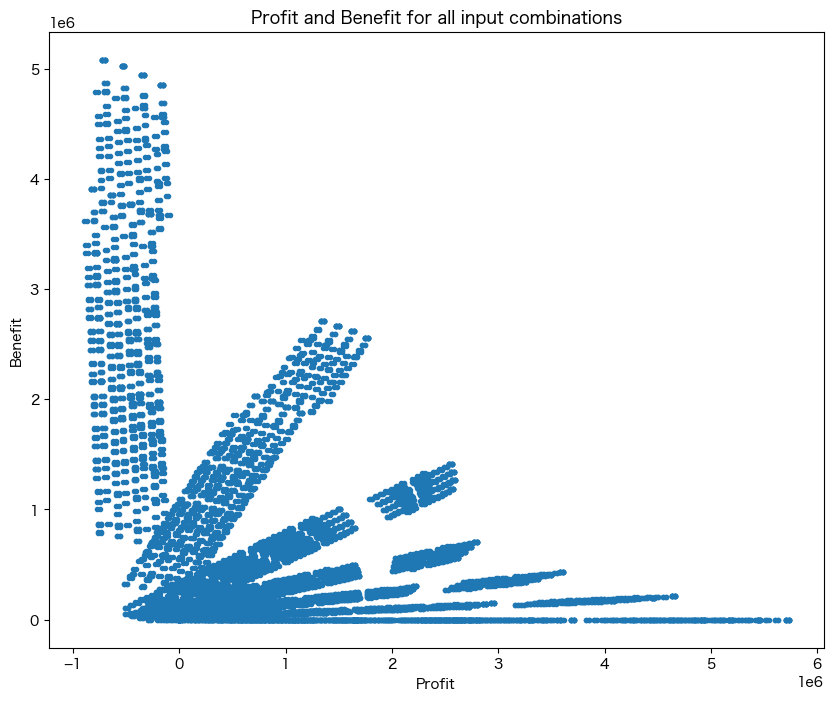

In [49]:
input_values = {
    'n_cars': 300,
    'weekday_starthour': 8,
    'weekday_startmin': 30,
    'weekday_endhour': 18,
    'weekday_endmin': 0,
    'holiday_starthour': 9,
    'holiday_startmin': 0,
    'holiday_endhour': 20,
    'holiday_endmin': 0,
    'charge_on_road': True,
    'service_lev': 5, 
    'once_fare': 500
}

main(input_values, input_ranges, need)
